# Compute beam-induced heating of CEI logo impedance

In [1]:
import sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.constants import c 

sys.path.append('../wakis/')
import wakis

sys.path.append('../IDDEFIX/')
import iddefix

sys.path.append('../BIHC')
import bihc

## Load the fully decayed simulation results computed in the notebook `003`

In [2]:
wake = wakis.WakeSolver(save=False)
wake.load_results('results_wl100/')
wake_length = 100

In [3]:
DE_model = iddefix.EvolutionaryAlgorithm(wake.s/c, # time [s]
                                         wake.WP*1e12/c, # [V/C]
                                         N_resonators=10,
                                         parameterBounds=None,
                                         plane='longitudinal',
                                         fitFunction='impedance',
                                         sigma=10e-2/c)

[!] Using the fully decayed resonator formalism for impedance


In [4]:
from io import StringIO
data_str = StringIO('''
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.17e+03        |      63.22       |    4.285e+08     
    2     |        8.09e+02        |      72.73       |    6.965e+08     
    3     |        2.43e+04        |      899.59      |    7.595e+08     
    4     |        8.71e+02        |      84.45       |    8.923e+08     
    5     |        1.21e+03        |      68.35       |    9.113e+08     
    6     |        5.68e+02        |      109.87      |    1.055e+09     
    7     |        8.26e+02        |      76.62       |    1.106e+09     
    8     |        1.06e+03        |      117.80      |    1.128e+09     
    9     |        6.83e+02        |      119.96      |    1.150e+09     
----------------------------------------------------------------------
''')

DE_model.minimizationParameters = np.loadtxt(data_str, 
                                            skiprows=4, max_rows=9, usecols=(1, 2, 3),
                                            delimiter='|', dtype=float,).flatten()

In [5]:
DE_model.display_resonator_parameters(DE_model.minimizationParameters )



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.17e+03        |      63.22       |    4.285e+08     
    2     |        8.09e+02        |      72.73       |    6.965e+08     
    3     |        2.43e+04        |      899.59      |    7.595e+08     
    4     |        8.71e+02        |      84.45       |    8.923e+08     
    5     |        1.21e+03        |      68.35       |    9.113e+08     
    6     |        5.68e+02        |      109.87      |    1.055e+09     
    7     |        8.26e+02        |      76.62       |    1.106e+09     
    8     |        1.06e+03        |      117.80      |    1.128e+09     
    9     |        6.83e+02        |      119.96      |    1.150e+09     
----------------------------------------------------------------------


Show fully decayed impedance

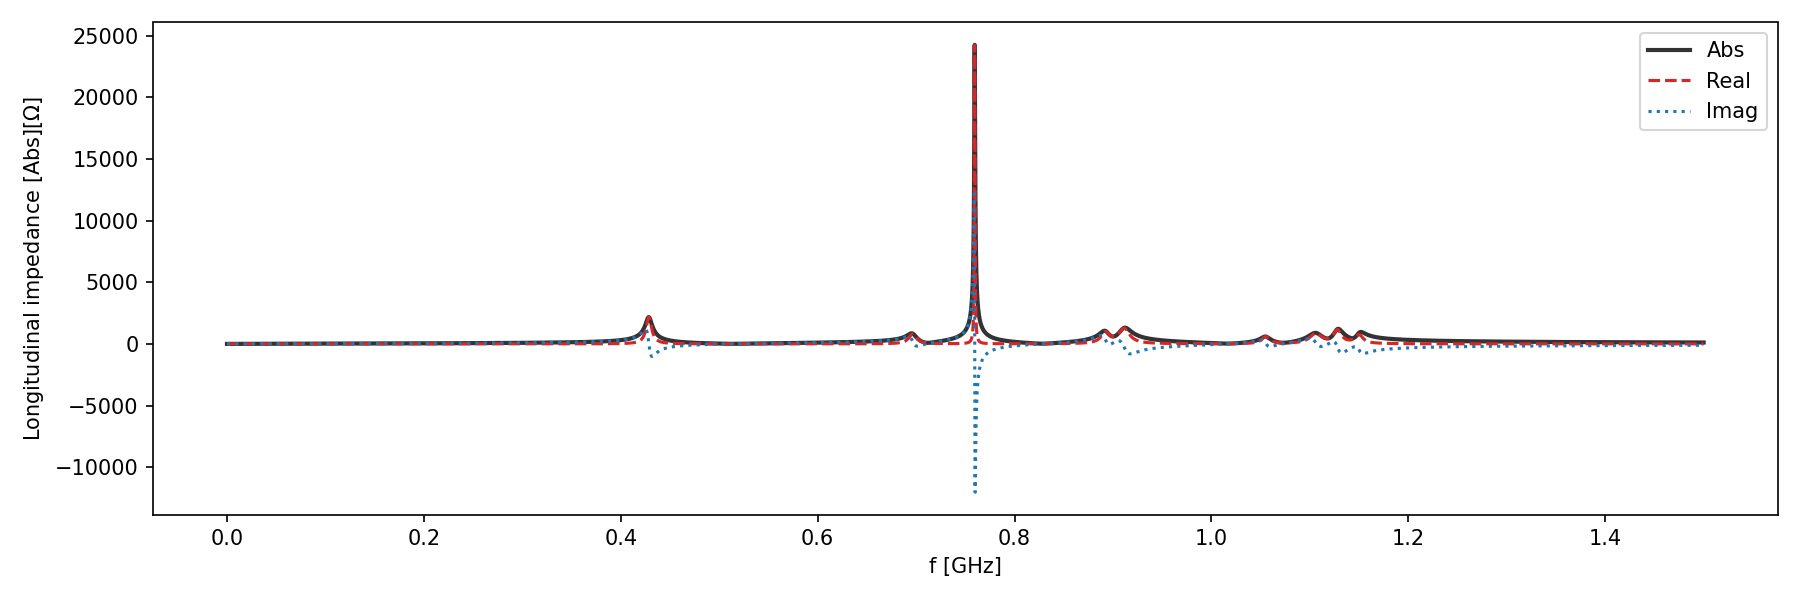

In [6]:
%matplotlib ipympl
f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)

fig1, ax = plt.subplots(1,1, figsize=[12,4], dpi=150)

ax.plot(f_fd*1e-9, np.abs(Z_fd), c='k', alpha=0.8, lw=2, label='Abs')
ax.plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:red', lw=1.5, label='Real')
ax.plot(f_fd*1e-9, np.imag(Z_fd), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax.set_xlabel('f [GHz]')
ax.set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='k')
ax.legend()

fig1.tight_layout()

And save to a txt:

In [7]:
DE_model.save_txt('004_fully_decayed_impedance.txt', f_fd, Z_fd)

## Generate beam parameters with `BIHC`

Let's imagine our CEI logo cavity is installed in the LHC and we need to estimate if the power loss due to impedance is high enough that it can melt or damage the component

First we define the beam filling scheme and build our beam:

In [8]:
def fillingSchemeLHC(ninj, ntrain=5, nbunches=36):
    '''
    Returns the filling scheme for the LHC 
    using the standard pattern

    Parameters
    ----------
    ninj: number of injections (batches)
    '''

    # Define filling scheme: parameters
    #ninj = 11 # Defining number of injections
    nslots = 3564 # Defining total number of slots for LHC
    #ntrain = 5 # Defining the number of trains
    #nbunches = 36 # Defining a number of bunchs e.g. 18, 36, 72.. 
    batchS = 7 # Batch spacing in 25 ns slots
    injspacing = 37 # Injection spacing in 25 ns slots

    # Defining the trains as lists of True/Falses
    bt = [True]*nbunches
    st = [False]*batchS
    stt = [False]*injspacing
    sc = [False]*(nslots-(ntrain*nbunches*ninj+((ntrain-1)*(batchS)*ninj)+((1)*injspacing*(ninj))))
    an1 = bt+ st +bt+ st+ bt+ st+ bt+ stt
    an = an1 * ninj + sc # This is the final true false sequence that is the beam distribution

    return an

In [9]:
# Create beam object
fillingScheme = fillingSchemeLHC(ninj=9, ntrain=4, nbunches=72)
bl = 1.2e-9                 # bunch length [s]
Np = 2.3e11                 # bunch intensity [protons/bunch]
bunchShape = 'q-GAUSSIAN'   # bunch profile shape in time 
qvalue = 3/5                # value of q parameter in the q-gaussian distribution
fillMode = 'FLATTOP'        # Energy
fmax = 2e9                  # Maximum frequency of the beam spectrum [Hz]

beam = bihc.Beam(Np=Np, bunchLength=bl, fillingScheme=fillingScheme,
                bunchShape=bunchShape, qvalue=qvalue, 
                machine='LHC', fillMode=fillMode, spectrum='numeric', fmax=fmax)

print(f'* Number of bunches used: {np.sum(fillingScheme)}')
print(f'* Total intensity: {np.sum(fillingScheme)*Np:.2e} protons')

Setting custom beam from filling scheme
Elaborating Data...
* Number of bunches used: 2592
* Total intensity: 5.96e+14 protons


We can plot the longitudinal profile in time domain and the beam spectrum in frequency domain:

(0.0, 2.0)

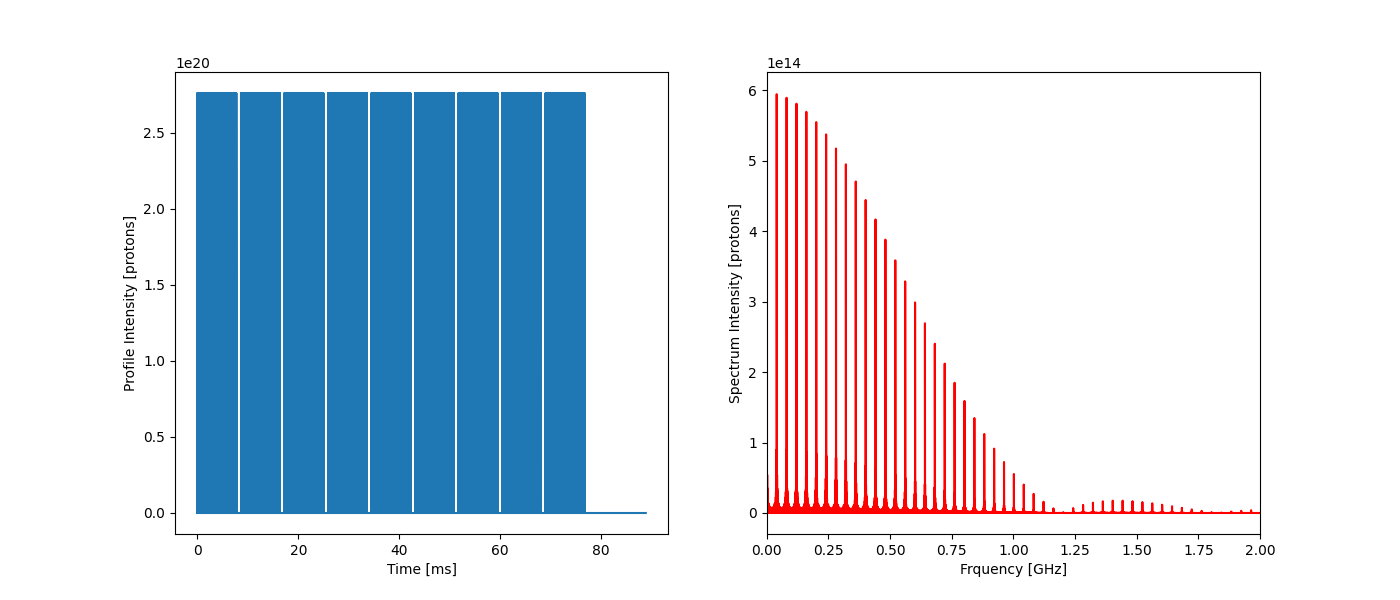

In [10]:
%matplotlib ipympl
fig, ax = plt.subplots(1,2, figsize=[14,6])

t, prof = beam.longitudinalProfile
ax[0].plot(t*1e6, prof*beam.Np,)
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Profile Intensity [protons]')

f, spectrum = beam.spectrum
ax[1].plot(f*1e-9, spectrum*beam.Np*np.sum(fillingScheme), c='r')
ax[1].set_xlabel('Frquency [GHz]')
ax[1].set_ylabel('Spectrum Intensity [protons]')
ax[1].set_xlim((0, 2.0))

The beam induced heating depends on the interaction of the beam power spectrum and the beam-coupling impedance. To assess it visually we can plot them together:

In [11]:
# We create an impedance object with BIHC:
Z = bihc.Impedance(f=f_fd, Z=Z_fd)

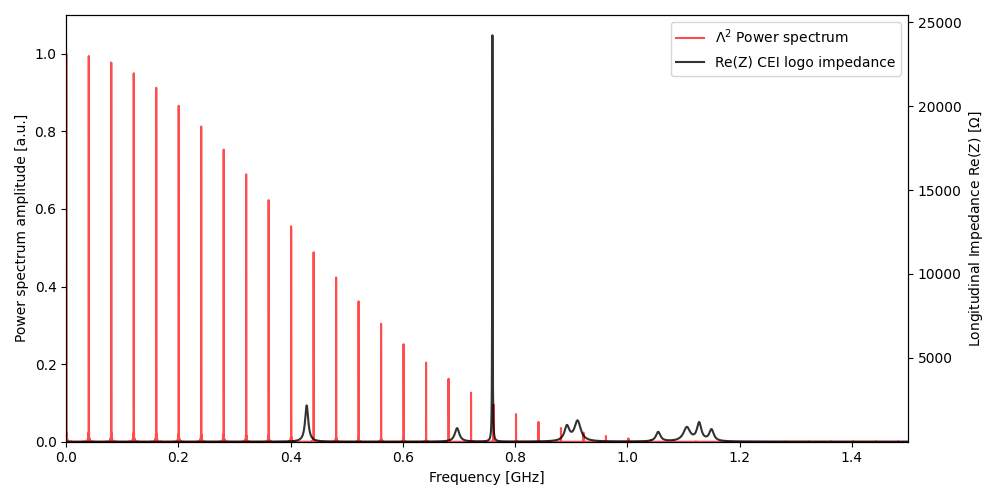

In [12]:
# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
#ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=0, ymax=1.1)

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
axx.set_ylim(ymin=1e-0) 
#axx.set_yscale('log')

axx.legend([l0, l1], [f'$\Lambda^2$ Power spectrum', 'Re(Z) CEI logo impedance'], loc=0)

fig.tight_layout()

## Calculate beam-induced heating

With `BIHC` we can simply calculate the power loss by `beam.getPloss(Z)`. However, due to inacuracies in the wakefield simulation or the CAD model, or to account for changes in the revolution frequency during operation, `BIHC` also performs a **statistical analysis** by rigidly shifting the impedance curve `beam.getShiftedPloss(Z, shift=shift)` to account for different overlaps with the beam spectral lines:

In [13]:
print('Calculate beam-induced heating of CEI logo impedance')
print('----------------------------------------------------')
# Get unshifted ploss 
ploss, ploss_density = beam.getPloss(Z) 
print(f'Dissipated power (no-shift): {ploss:.3} W')

# Get min/max power loss with rigid shift
shift = 20e6  # distance between shift steps [Hz]
shifts, power = beam.getShiftedPloss(Z, shift=shift)

print(f'Minimum dissipated power: P_min = {np.min(power):.3} W, at step {shifts[np.argmin(power)]}')
print(f'Maximum dissipated power: P_max = {np.max(power):.3} W, at step {shifts[np.argmax(power)]}')
print(f'Average dissipated power: P_mean = {np.mean(power):.3} W')

Calculate beam-induced heating of CEI logo impedance
----------------------------------------------------
Dissipated power (no-shift): 8.82e+02 W


Computing scan: 100%|██████████| 3556/3556 [00:24<00:00, 143.62it/s]

Minimum dissipated power: P_min = 4.83e+02 W, at step -392
Maximum dissipated power: P_max = 7.3e+03 W, at step 176
Average dissipated power: P_mean = 1.43e+03 W


We can now retrieve and plot the impedance curve that gives the maximum power loss. We can observe that when the peak at 760 MHz is shifted and placed exactly on top of the beam spectral line, the power loss dramatically increases

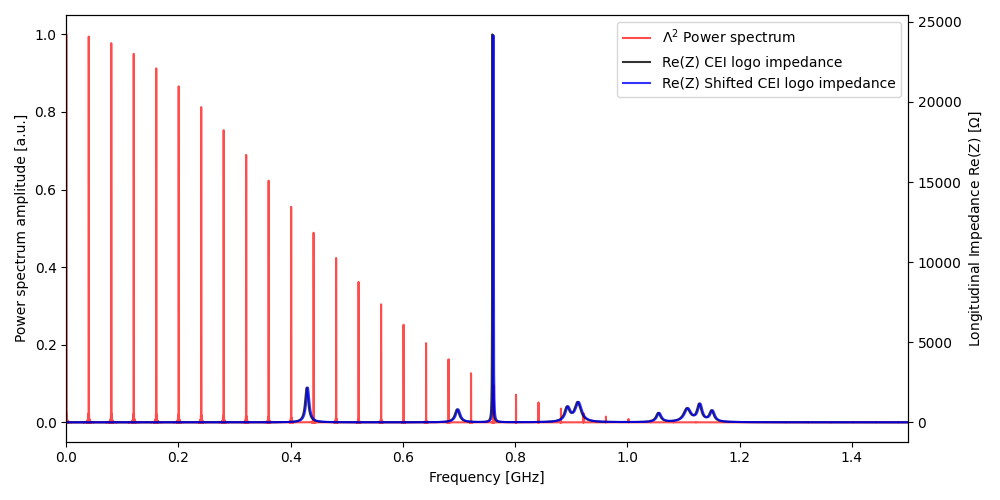

In [14]:
# Get unshifted ploss max
Z_max = beam.Zmax

# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')
l2, = axx.plot(Z_max.f/1e9, Z_max.Zr, color='b', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
#ax.set_ylim(ymin=1e-3, ymax=1.1)
#ax.set_yscale('log')

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
#axx.set_ylim(ymin=1e-1, ymax=1e5) 
#axx.set_yscale('log')

axx.legend([l0, l1, l2], [f'$\Lambda^2$ Power spectrum', 'Re(Z) CEI logo impedance', 'Re(Z) Shifted CEI logo impedance'], loc=0)

fig.tight_layout()

We can also plot the power loss by frequency with the power loss density:

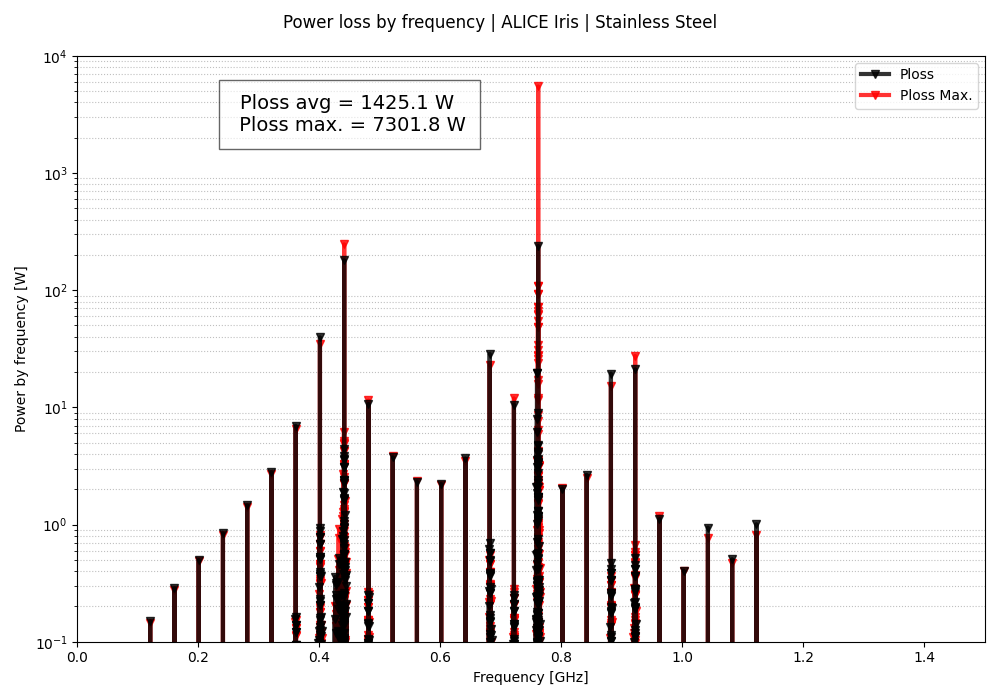

In [15]:
fig, ax = plt.subplots(figsize=[10,7])

# Unshifted impedance
ploss, ploss_density = beam.getPloss(Z) 

# Shifted impedance
ploss_max, ploss_density_max = beam.getPloss(Z_max) 

l1, = ax.plot(np.linspace(0, Z_max.f.max()/1e9, len(ploss_density_max )), ploss_density_max , color='r', marker='v', lw=3, alpha=0.8)
l0, = ax.plot(np.linspace(0, Z.f.max()/1e9, len(ploss_density )), ploss_density , color='k', marker='v', lw=3, alpha=0.8)

ax.set_ylabel('Power by frequency [W]', color='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=1e-1, ymax=1e4)
ax.grid(which='minor', axis='y', alpha=0.8, ls=':')

ax.legend([l0, l1, l2], [f'Ploss', 'Ploss Max.'], loc=1)
ax.text(0.3, 0.9, f'Ploss avg = {round(np.mean(power ),2)} W \n Ploss max. = {round(np.max(power ),2)} W',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        bbox ={'facecolor':'white','alpha':0.6, 'pad':10},
        color='k', fontsize=14)

fig.suptitle('Power loss by frequency | ALICE Iris | Stainless Steel')
fig.tight_layout()

If the CEI logo cavity was placed in a common-beam chamber, it would see the effect of **2 beam power loss**. The beam-induced heating in this case is a function of the distance with the interaction point (IP) and can be greater than a factor 2 of the 1-beam case. 
We can compute this with `BIHC` too:

In [17]:
 #       2 beam case
# ----------------------
# Defining the phase shift array for LHC
c = 299792458 # Speed of light in vacuum [m/s]
ring_circumference =  26658.883   #[m]

start = -3.5 #m
stop = 3.5 #m
resolution = 0.001 #m power2b

s = np.arange(start, stop, resolution)
tau_s = 2*s/c # Phase shift array [s]

power2b = beam.get2BeamPloss(Z, tau_s=tau_s)
power2b_max = beam.get2BeamPloss(Z_max, tau_s=tau_s)

Computing 2-beam power: 100%|██████████| 7000/7000 [00:43<00:00, 161.74it/s]


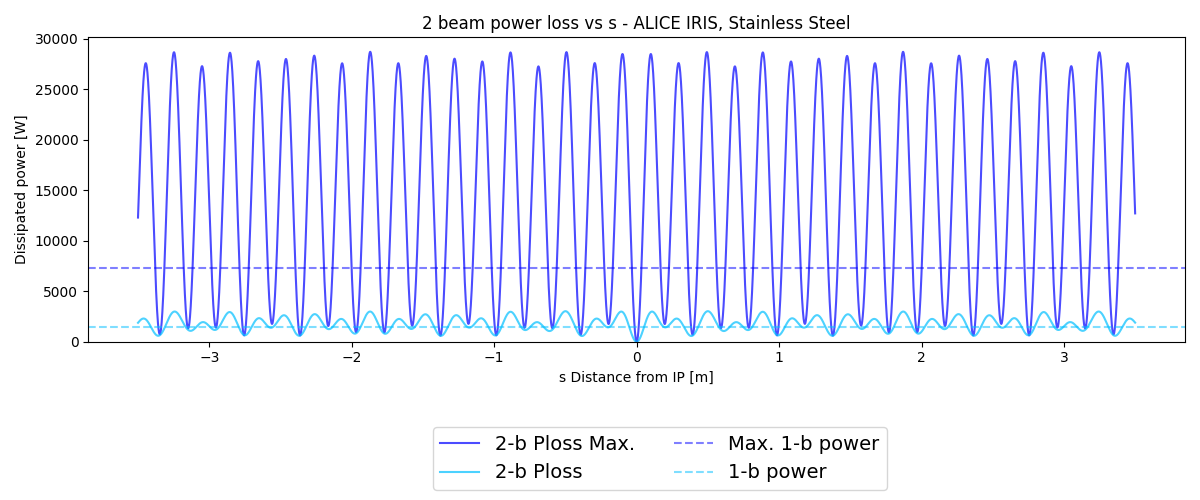

In [22]:
# Plot power los vs distance from IP, qgaussian
fig, ax = plt.subplots(figsize=[12,5])

ax.plot(s, power2b_max, label="2-b Ploss Max.", c='b', ls='-', alpha=0.7)
ax.plot(s, power2b, label="2-b Ploss ", c='deepskyblue', ls='-', alpha=0.7)

ax.set_ylabel('Dissipated power [W]')
ax.set_xlabel('s Distance from IP [m]')

ax.axhline(np.max(power), c='b', ls='--', alpha=0.5, label='Max. 1-b power')
ax.axhline(np.mean(power), c='deepskyblue', ls='--', alpha=0.5, label='1-b power')

ax.set_ylim(ymin=0)
ax.set_title(f'2 beam power loss vs s - ALICE IRIS, Stainless Steel')
fig.legend(bbox_to_anchor=(0.55, 0.0), fontsize=14, loc='lower center', ncol=2)
fig.tight_layout(rect=[0, 0.2, 1, 1])

### Mode by mode power loss [TODO]

### Power loss map [TODO]